In [ ]:
import pandas as pd
import math
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
should_add_k_for_unseen = True

In [ ]:
class NaiveBayes:
    """Naive Bayes classifier."""

    def __init__(self):
        self.ngram_count = []
        self.total_count = []
        self.category_prob = []

    def fit(self, data):
        self.vectorizer = CountVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))
        self.vectorizer.fit(data['text'].str.lower())
        x = self.vectorizer.transform(data['text'].str.lower())
        x_legitimate = x[data['label'] == 0]
        x_clickbait = x[data['label'] == 1]
        self.ngram_count.append(np.array(x_legitimate.sum(axis = 0)).flatten())
        self.ngram_count.append(np.array(x_clickbait.sum(axis = 0)).flatten())
        self.total_count.append(np.sum(self.ngram_count[0]))
        self.total_count.append(np.sum(self.ngram_count[1]))
        total = len(data)
        num_legitimate = len(data[data['label'] == 0])
        num_clickbait = len(data[data['label'] == 1])
        self.category_prob = [num_legitimate / total, num_clickbait / total]
        ###################################################################
        # TODO: store ngram counts for each category in self.ngram_count
        ###################################################################

        pass

        ###################################################################

    def calculate_prob(self, docs, c_i):
        prob = []
        texts = self.vectorizer.transform(doc.lower() for doc in docs)

        for text in texts:
            p = 0
            for i, value in enumerate(text.toarray()[0]):
                if value:
                    smoothed_count = self.ngram_count[c_i][i] + 1
                    total_count = self.total_count[c_i] + len(self.vectorizer.vocabulary_)
                    p += np.log(smoothed_count / total_count) * value

            p += np.log(self.category_prob[c_i])
            prob.append(p)

        return prob

    def predict(self, docs):
        prediction = [None] * len(docs)
        all = []
        all.append(self.calculate_prob(docs, 0))
        all.append(self.calculate_prob(docs, 1))
        for i in range(len(docs)):
            if all[0][i] > all[1][i]:
                prediction[i] = 0
            else:
                prediction[i] = 1
        ###################################################################
        # TODO: predict categories for the headlines
        ###################################################################

        ###################################################################

        return prediction


def evaluate(predictions, labels):
    total_samples = len(predictions)

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    micro_f1_numerator = 0
    micro_f1_denominator = 0

    for prediction, label in zip(predictions, labels):
        if prediction == 1 and label == 1:
            true_positives += 1
        elif prediction == 1 and label == 0:
            false_positives += 1
        elif prediction == 0 and label == 1:
            false_negatives += 1
        elif prediction == 0 and label == 0:
            true_negatives += 1
    accuracy = (true_positives + true_negatives) / total_samples

    precision_class0 = true_negatives / (true_negatives + false_positives)
    precision_class1 = true_positives / (true_positives + false_negatives)
    recall_class0 = true_negatives / (true_negatives + false_negatives)
    recall_class1 = true_positives / (true_positives + false_positives)

    macro_precision = (precision_class0 + precision_class1) / 2
    macro_recall = (recall_class0 + recall_class1) / 2
    macro_f1 = (2 * macro_precision * macro_recall) / (macro_precision + macro_recall)


    micro_f1_numerator += true_positives + true_negatives
    micro_f1_denominator += (true_positives + false_positives+true_negatives+false_negatives)
    micro_f1 = micro_f1_numerator / micro_f1_denominator

    return accuracy, macro_f1

In [ ]:
def load_headlines(filename):
    selected_columns = ['text', 'label']
    df = pd.read_csv(filename, usecols=selected_columns)
    return df

In [ ]:
naive_bayes = NaiveBayes()
all_data = load_headlines('swap.csv')
(train, test) = train_test_split(all_data, train_size=0.9)
naive_bayes.fit(train)

In [ ]:
predictions = naive_bayes.predict(test.text.tolist())
labels = test.label.tolist()
accuracy, mac_f1 = evaluate(predictions, labels)
print(f"Accuracy: {accuracy}")
print(f"Macro f1: {mac_f1}")

Accuracy: 0.8053097345132744
Macro f1: 0.7896368501529053


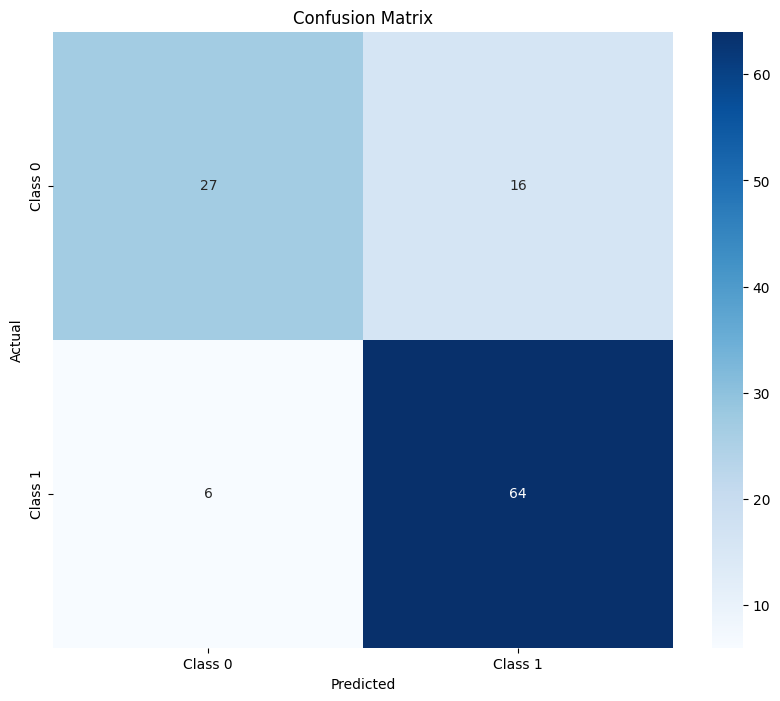

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()